# Markov Chain Monte Carlo (MCMC)
--------------------------------
### Applying markov chain monte carlo to find structural breaks in the sea level rise

This notebook describes a markov chain monte carlo (MCMC) analysis with which structural breaks in the sea level trend can be discovered. The MCMC method has the powerful ability to find probability density functions of a parameters in a given model.

In [1]:
import io

# Number crunching
import numpy as np
import pandas as pd

# The Python MC library
import pymc

# Plotting
import matplotlib.pyplot as plt
import pymc.Matplot as mcplt

# Initialize modules for the jupyter notebook format
from nbformat import current

plt.style.use('bmh')
%matplotlib inline

C:\Anaconda3\lib\site-packages\nbformat\current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


### Load data

Load the annual mean sea level data from PSMSL. For this we use the get-data notebook, which functions as a python library with some pre-defined io routines.

In [2]:
def execute_notebook(nbfile):
    """Function to run other notebook in this notebook"""
    with io.open(nbfile,encoding="utf8") as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)


In [3]:
execute_notebook(r'd:\Documents\GitHub\sealevel\notebooks\analysis\satellite\get-data.ipynb')

Give all Dutch station names, and download the data for these stations.

In [4]:
station_names = [
    'Vlissingen', 
    'Hoek van Holland', 
    'Den Helder', 
    'Delfzijl', 
    'Harlingen', 
    'IJmuiden'
]
# Locatie wind data is 50 km uit kust vanuit IJmuiden
rlr_data = get_station_data(dataset_name='rlr_annual', coastline_code=150, names=station_names)

found point 52.3799 3.75
rlr_annual 20 rlr
rlr_annual 22 rlr
rlr_annual 23 rlr
rlr_annual 24 rlr
rlr_annual 25 rlr
rlr_annual 32 rlr


In the cell below it is possible to define what stations need to be taken into account for calculating the mean annual sea level. By default we use the average of all six stations. You can vary this if you want to apply the model on a specific station.

In [5]:
stations = [20, 22, 23, 24, 25, 32]

grouped = pandas.concat(rlr_data.loc[stations, 'data'].tolist())[['year', 'height', 'u2', 'v2']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890]

station_names = [st.capitalize() for st in rlr_data.loc[stations, 'name'].tolist()]

print(f'Stations of which the data is used: {", ".join(station_names)}')

Stations of which the data is used: Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden


Assign part of the dataframes to other variables. These data (time, height, wind speeds squared) are used globally throughout the notebook.

In [6]:
t = np.asarray(mean_df['year'].values)
y = np.asarray(mean_df['height'].values)

wind_u2 = np.asarray(mean_df['u2'].values)
wind_v2 = np.asarray(mean_df['v2'].values)

y_obs = y
t=t

What the MCMC algorithm basically does, is we give it the sea level rise model (a relation between parameters), and this data that should match the model we observed. The algorithm then finds the distributions for the parameters in our model.

To verify how this works, we first try to find the parameters for the linear sea level rise model with wind, currently  'best fitting' and thus prevailing model. To do so we define the model and the input parameters. The model:

$H(t) = a + b_{trend}(t) + b_u\cos(\frac{2\pi t}{18.613}) + b_v\sin(\frac{2\pi t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t)$
    
Note that there is no autocorrelation term (yet).

Now we need to define our prior parameter distributions. It helps to have an idea of the 'correct' values, so the sampling algorithm quickly finds the right sampling regions. However to test if the model functions as it should, we give it a wide starting range:

- $b_{trend}$: normally distributed with mean 0 and standard deviation 1.
- The nodal and wind coefficients: uniformly distributed between -20 and 20.
- The constant: depends on the ohter parameters, so we giva an uniform range of the min to the max value.
- The variantion: Uniform distributed between 0 and 50.

In [7]:
# The linear trend
b_trend = pymc.Normal(name='Trend', mu=0, tau=1)

# The nodal components
b_nodalx = pymc.Uniform('Nodal U', -20, 20)
b_nodaly = pymc.Uniform('Nodal V', -20, 20)

# The wind components
b_windx = pymc.Uniform('Wind U^2', -20, 20)
b_windy = pymc.Uniform('Wind V^2', -20, 20)

# The constant
a = pymc.Uniform(name='Constant', lower=mean_df['height'].min(), upper=mean_df['height'].max())

# The variation
sigma = pymc.Uniform('Sigma', 0.0, 50) 

In [8]:
# Define the model with which the annual mean sea level can be calculated.
def modelled_y(a, b_trend, b_nodalx, b_nodaly, b_windx, b_windy):
    '''Compute sea level from coefficients'''
    # t70 gives the time relative to 1970 the switchpoint
    t70 = t - 1970
    
    # The trend to describe the linear sea level rise
    trend = t70 * b_trend
    
    # Nodal x, nodal y; the 18.6 year nodal cycle. Sin and cos together describe phase and amplitude
    nodalx = b_nodalx * np.cos(2*np.pi*t70/18.613)
    nodaly = b_nodaly * np.sin(2*np.pi*t70/18.613)

    # Wind components
    windx = b_windx * wind_u2
    windy = b_windy * wind_v2
    
    # Resulting sea level pattern
    out = a + trend + nodalx + nodaly + windx + windy
    return out

# Create a deterministic pymc function, which is used in the sampling.
@pymc.deterministic(plot=True)
def pymc_y(a=a, b_trend=b_trend, b_nodalx=b_nodalx, b_nodaly=b_nodaly, b_windx=b_windx, b_windy=b_windy):
    return modelled_y(a, b_trend, b_nodalx, b_nodaly, b_windx, b_windy)
    

Now we define the dependent variable (mean annual sea level) as an observed node. 

In [9]:
y = pymc.Normal('y', mu=pymc_y, tau=1.0/sigma**2, value=y_obs, observed=True)

Run the MCMC model.
iter is the number of iterations, burn is the part of the iterations we drop, thin is the 1/thin part we use. This avoides the autocorrelation which is inseperable from the MCMC model.

In [10]:
M = pymc.MCMC(pymc.Model([y, a, b_trend, sigma, b_nodalx, b_nodaly, b_windx, b_windy]))
M.sample(iter=40000, burn=10000, thin=20)

 [-----------------100%-----------------] 40000 of 40000 complete in 20.5 sec

The next plots show the traces of the iterations. Note that we have discarded the first 10000 samples as 'spin-up', and thinned the whole by 20, for lessening the autocorrelation. The traces show the variation in the possible outcomes.

Plotting Trend
Plotting Nodal U
Plotting Sigma
Plotting Wind V^2
Plotting Nodal V
Plotting Wind U^2
Plotting Constant


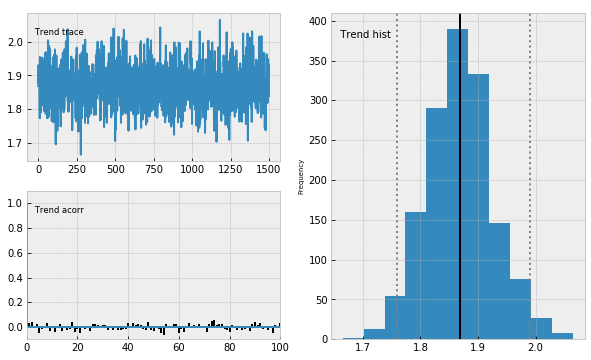

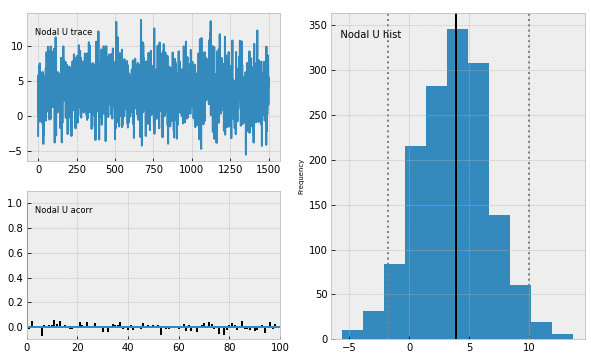

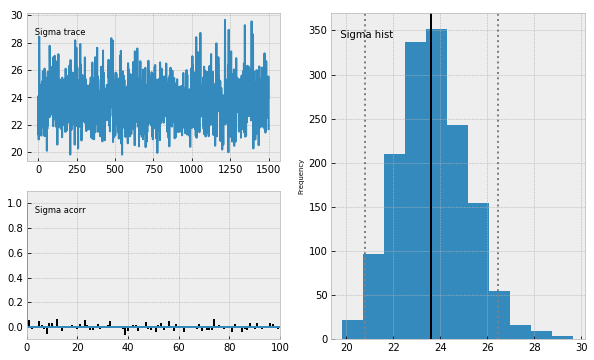

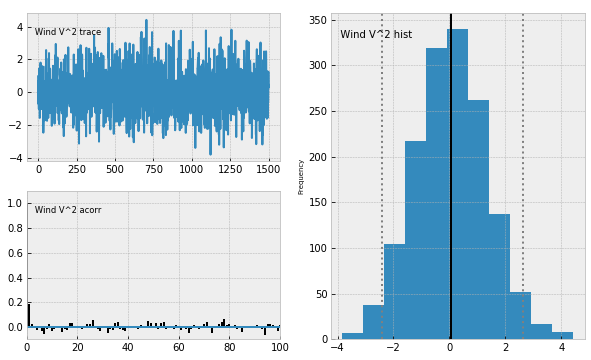

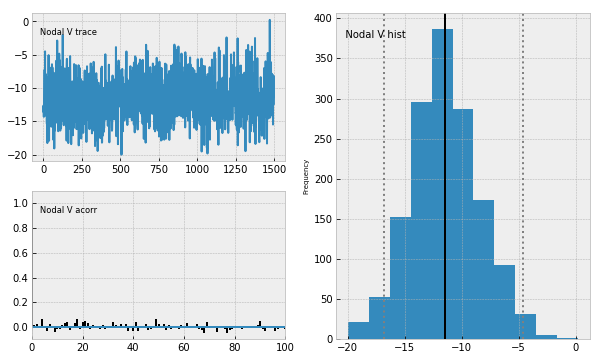

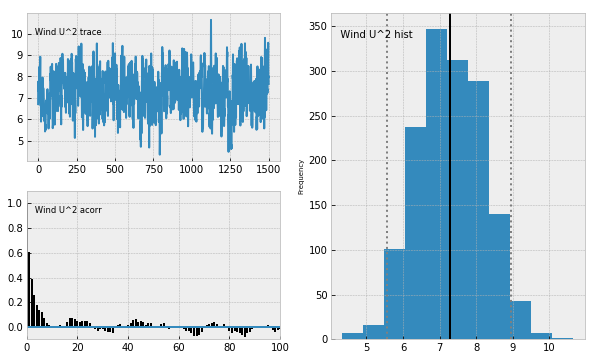

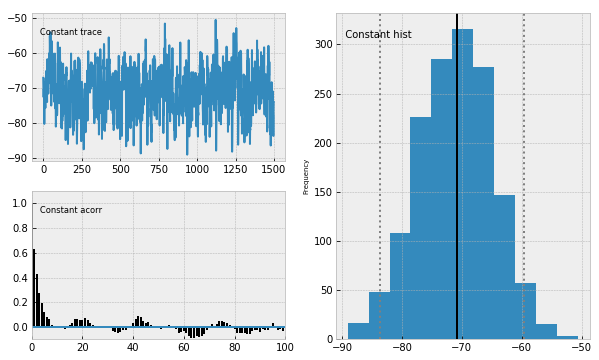

In [11]:
mcplt.plot(M)

On the right the histograms of each parameter is shown. We will compare these to the parameters in the linear model. To do so, import the default linear model and plot the histograms again with the results of the linear model.

In [12]:
# Fit the linear model
linear_fit, names = linear_model(mean_df, with_wind=True, with_season=False)
table = linear_fit.summary(yname='Sea-surface height', xname=names, title='Linear model without (1890-current)')

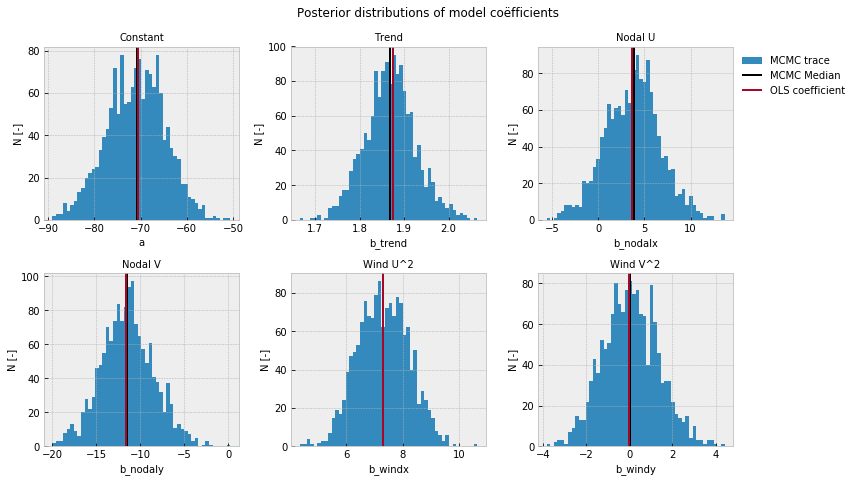

In [13]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 7))
axs = axs.ravel()

overview = []

for i, (name, parent) in enumerate(pymc_y.parents.items()):
    
    ax = axs[i]
    
    trace = M.trace(parent.__name__)[:]
    ax.hist(trace, bins=50, label='MCMC trace')
    ax.set_title(parent.__name__, fontsize=10)
    ylim = ax.get_ylim()
    ax.set_ylim(*ylim)
    
    # Get parameters from linear model
    j = names.index(parent.__name__)
    overview.append([linear_fit.params.values[j], linear_fit.HC0_se.values[j], np.median(trace), np.std(trace)])
    
    ax.vlines([np.median(trace)], *ylim, colors=['k'], label='MCMC Median')
    ax.vlines([linear_fit.params.values[j]], *ylim, colors=['C1'], label='OLS coefficient')
    
    ax.set_xlabel(name, fontsize=10)
    ax.set_ylabel('N [-]', fontsize=10)
    
    if i == 2:
        ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
   
fig.suptitle('Posterior distributions of model coëfficients')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    


The regression coefficients match very good with the MCMC medians. We can also observe the distributions of the variables. Note that these do not match witch the input distributions (mostly Uniform).

We also compare the standard errors of both models:

In [14]:
overview = pd.DataFrame(
    data = overview,
    columns=pd.MultiIndex.from_product([('OLS', 'MCMC'), ('coef', 'std err')]),
    index=names
)

overview

OLS                 MCMC          
               coef   std err       coef   std err
Constant -70.662367  5.379188 -70.796628  6.266224
Trend      1.874865  0.054995   1.869436  0.057460
Nodal U    3.713045  2.863882   3.893970  2.980569
Nodal V  -11.582004  2.878221 -11.491835  3.012200
Wind U^2   7.290216  0.734160   7.294903  0.902272
Wind V^2   0.004152  1.086441   0.044764  1.274593

Now we plot both models together with the observed data:

Text(0.5,1,'Markov-Chain Monte Carlo')

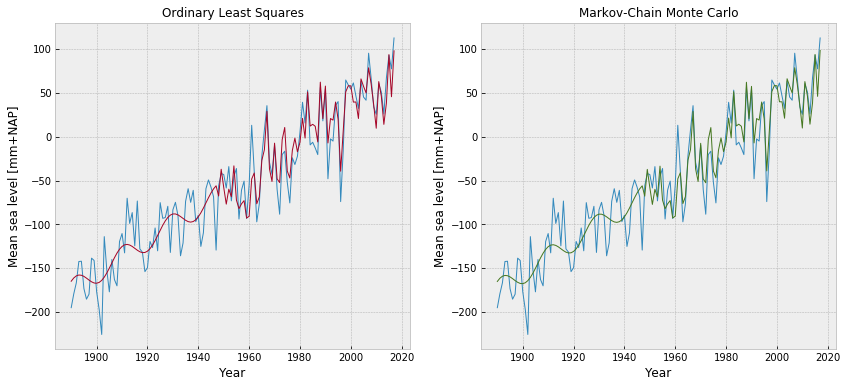

In [15]:
# Get values from model
args = {}
for name, parent in pymc_y.parents.items():
    args[name] = np.median(M.trace(parent.__name__)[:])
    
y_model = modelled_y(**args)
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

for ax in axs:
    ax.plot(t, y_obs, lw=1.0)
    ax.set_ylabel('Mean sea level [mm+NAP]')
    ax.set_xlabel('Year')

ax = axs[0]
ax.plot(t, y_model, lw=1.0)
ax.set_title('Ordinary Least Squares', fontsize=12)

ax = axs[1]
ax.plot(mean_df['year'], linear_fit.fittedvalues, lw=1.0, color='C3')
ax.set_title('Markov-Chain Monte Carlo', fontsize=12)

### Detecting Trend Breaks

In the previous analysis we saw that the MCMC method can be used to detect to find the sea level rise trend without any prior knowledge of the distributions. We use this feature to add a extra trend and switchpoint. We define two extra parameters, and two models to find the trend breaks:
1. The linear model with nodal cycle (18.6 years);
2. The linear model with nodal cycle wind.

A comparison between the two can show us the effect of the short wind series on a potential trend break.

In [16]:
# First define two extra stochasts.
# The 'extra' trend. Note that the previous trend is also included before the switchpoint.
b_trend2_nw = pymc.Normal(name='Trend after switchpoint_nw', mu=0, tau=1)
# The switchpoint, unifomrly distributed between 1900 and 2000
s_nw = pymc.Uniform('switchpoint_nw', lower=1900, upper=2000)

In [17]:
# Redefine other variables
b_trend_nw = pymc.Normal(name='Trend_nw', mu=0, tau=1)
b_nodalx_nw = pymc.Uniform('Nodal U_nw', -20, 20)
b_nodaly_nw = pymc.Uniform('Nodal V_nw', -20, 20)
b_windx_nw = pymc.Uniform('Wind U^2_nw', -20, 20)
b_windy_nw = pymc.Uniform('Wind V^2_nw', -20, 20)
a_nw = pymc.Uniform(name='Constant_nw', lower=mean_df['height'].min(), upper=mean_df['height'].max())
sigma_nw = pymc.Uniform('Sigma_nw', 0.0, 50)


def modelled_break_no_wind_y(a, s, b_trend, b_trend2, b_nodalx, b_nodaly):
    '''Compute sea level from coefficients including trend break'''
    
    # The trend to describe the linear sea level rise
    t70 = t - 1970
    ts = t - s
    trend1 = t70 * b_trend
    trend2 = ts * (ts > 0) * b_trend2
    
    # Nodal x, nodal y; the 18.6 year nodal cycle. Sin and cos together describe phase and amplitude
    nodalx = b_nodalx * np.cos(2*np.pi*t70/18.613)
    nodaly = b_nodaly * np.sin(2*np.pi*t70/18.613)

    # Resulting sea level pattern
    out = a + trend1 + trend2 + nodalx + nodaly
    return out

# Create a deterministic pymc function
@pymc.deterministic(plot=True)
def pymc_break_no_wind_y(a=a_nw, s=s_nw, b_trend=b_trend_nw, b_trend2=b_trend2_nw, b_nodalx=b_nodalx_nw, b_nodaly=b_nodaly_nw):
    return modelled_break_no_wind_y(a, s, b_trend, b_trend2, b_nodalx, b_nodaly)

# Redefine all variables
b_trend_ww = pymc.Normal(name='Trend_ww', mu=0, tau=1)
b_trend2_ww = pymc.Normal(name='Trend after switchpoint_ww', mu=0, tau=1)
b_nodalx_ww = pymc.Uniform('Nodal U_ww', -20, 20)
b_nodaly_ww = pymc.Uniform('Nodal V_ww', -20, 20)
b_windx_ww = pymc.Uniform('Wind U^2_ww', -20, 20)
b_windy_ww = pymc.Uniform('Wind V^2_ww', -20, 20)
a_ww = pymc.Uniform(name='Constant_ww', lower=mean_df['height'].min(), upper=mean_df['height'].max())
sigma_ww = pymc.Uniform('Sigma_ww', 0.0, 50)
s_ww = pymc.Uniform('switchpoint_ww', lower=1900, upper=2000)

def modelled_break_with_wind_y(a, s, b_trend, b_trend2, b_nodalx, b_nodaly, b_windx, b_windy):
    '''Compute sea level from coefficients including trend break with wind'''
    
    t70 = t - 1970
        
    # The trend to describe the linear sea level rise
    ts = t - s
    trend1 = t70 * b_trend
    trend2 = ts * (ts > 0) * b_trend2
    
    # Nodal x, nodal y; the 18.6 year nodal cycle. Sin and cos together describe phase and amplitude
    nodalx = b_nodalx * np.cos(2*np.pi*t70/18.613)
    nodaly = b_nodaly * np.sin(2*np.pi*t70/18.613)

    # Wind components
    windx = b_windx * wind_u2
    windy = b_windy * wind_v2
    
    # Resulting sea level pattern
    out = a + trend1 + trend2 + nodalx + nodaly + windx + windy
    return out

# Create a deterministic pymc function
@pymc.deterministic(plot=True)
def pymc_break_with_wind_y(a=a_ww, s=s_ww, b_trend=b_trend_ww, b_trend2=b_trend2_ww, b_nodalx=b_nodalx_ww, b_nodaly=b_nodaly_ww, b_windx=b_windx_ww, b_windy=b_windy_ww):
    return modelled_break_with_wind_y(a, s, b_trend, b_trend2, b_nodalx, b_nodaly, b_windx, b_windy)
    

Run all models, use 40000 iteration, 10000 burns and 20 thinning.

In [18]:
y_no_wind = pymc.Normal('y_no_wind', mu=pymc_break_no_wind_y, tau=1.0/sigma_nw**2, value=y_obs, observed=True)
M_break_no_wind = pymc.MCMC(pymc.Model([y_no_wind, a_nw, s_nw, b_trend_nw, b_trend2_nw, sigma_nw, b_nodalx_nw, b_nodaly_nw]))
M_break_no_wind.sample(iter=40000, burn=20000, thin=20)

y_with_wind = pymc.Normal('y_with_wind', mu=pymc_break_with_wind_y, tau=1.0/sigma_ww**2, value=y_obs, observed=True)
M_break_with_wind = pymc.MCMC(pymc.Model([y_with_wind, a_ww, s_ww, b_trend_ww, b_trend2_ww, sigma_ww, b_nodalx_ww, b_nodaly_ww, b_windx_ww, b_windy_ww]))
M_break_with_wind.sample(iter=40000, burn=20000, thin=20)

 [-----------------100%-----------------] 40000 of 40000 complete in 28.0 sec

We plot the trace and histogram

Plot the resulting histogram of the switchpoints for both models. These histograms can show the certainty of a potential switchpoint; the narrower the clearer the switchpoint.

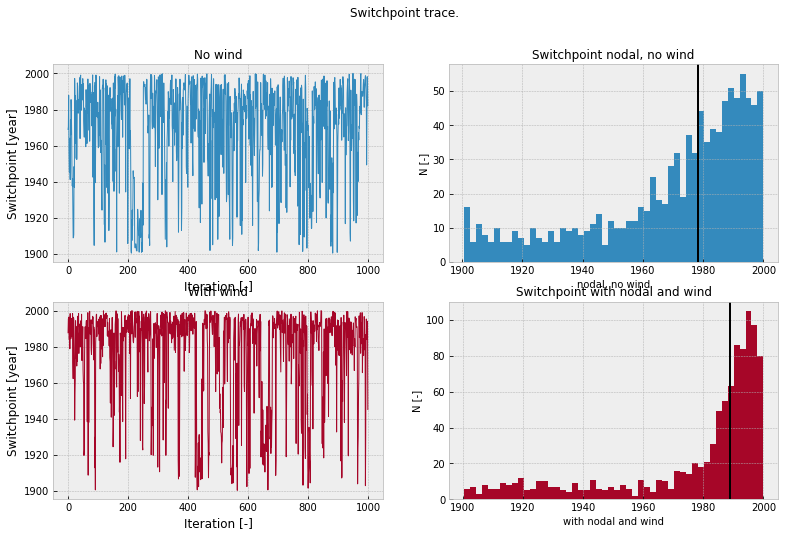

In [19]:
fig, axs = plt.subplots(figsize=(13, 8), nrows=2, ncols=2)

axs[0, 0].plot(s_nw.trace[:], lw=1.0, color='C0')
axs[1, 0].plot(s_ww.trace[:], lw=1.0, color='C1')
axs[0, 0].set_title('No wind', fontsize=12)
axs[1, 0].set_title('With wind', fontsize=12)

fig.suptitle('Switchpoint trace.')
for ax in axs[:, 0]:
    ax.set_xlabel('Iteration [-]')
    ax.set_ylabel('Switchpoint [year]')
    
    
for i, (ax, model, name, ad) in enumerate(zip(
    axs[:, 1], [M_break_no_wind, M_break_with_wind], ['nodal, no wind', 'with nodal and wind'], ['nw', 'ww'])):
#     if i < 2:
#         continue

    trace = model.trace(f'switchpoint_{ad}')[:]
    ax.hist(trace, bins=50, label='MCMC trace', color=f'C{i}')
    ax.set_title(f'Switchpoint {name}', fontsize=12)

    ylim = ax.get_ylim()
    ax.set_ylim(*ylim)
    ax.vlines([np.median(trace)], *ylim, colors=['k'], label='MCMC Median')
    
    ax.set_xlabel(name, fontsize=10)
    ax.set_ylabel('N [-]', fontsize=10)
    
    if i == 1:
        ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)


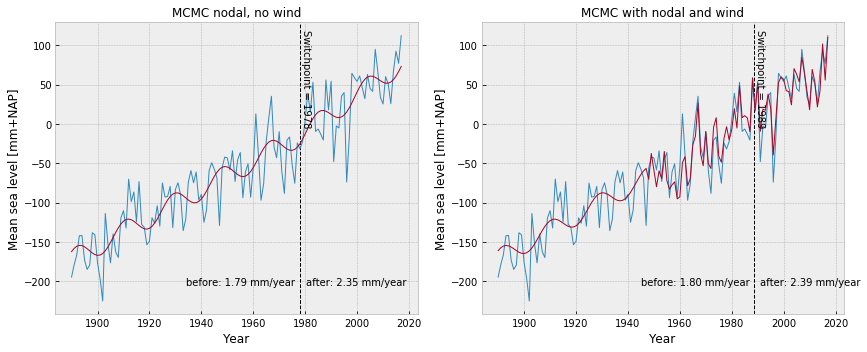

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs = axs.ravel()

for ax in axs:

    ax.plot(t, y_obs, lw=1.0)
    ax.set_ylabel('Mean sea level [mm+NAP]')
    ax.set_xlabel('Year')
    
    ylim = ax.get_ylim()
    ax.set_ylim(*ylim)

ax = axs[0]

# Get values from model
args = {}
for name, parent in pymc_break_no_wind_y.parents.items():
    args[name] = np.median(M_break_no_wind.trace(parent.__name__)[:])
y_model = modelled_break_no_wind_y(**args)

ax.plot(t, y_model, lw=1.0)
ax.set_title('MCMC nodal, no wind', fontsize=12)

ax.vlines([args['s']], *ylim, linestyle='--', linewidth=1.0)
ax.text(args['s']-2, ylim[0] + 0.1 * np.diff(ylim), f"before: {args['b_trend']:4.2f} mm/year", ha='right')
ax.text(args['s']+2, ylim[0] + 0.1 * np.diff(ylim), f"after: {args['b_trend2'] + args['b_trend']:4.2f} mm/year", ha='left')
ax.text(args['s']+0.1, ylim[1] - 0.05 * np.diff(ylim), f"Switchpoint = {args['s']:.0f}", rotation=-90)

ax = axs[1]

# Get values from model
args = {}
for name, parent in pymc_break_with_wind_y.parents.items():
    args[name] = np.median(M_break_with_wind.trace(parent.__name__)[-1000:])
y_model = modelled_break_with_wind_y(**args)

ax.plot(t, y_model, lw=1.0)
ax.set_title('MCMC with nodal and wind', fontsize=12)

ax.vlines([args['s']], *ylim, linestyle='--', linewidth=1.0)
ax.text(args['s']-2, ylim[0] + 0.1 * np.diff(ylim), f"before: {args['b_trend']:4.2f} mm/year", ha='right')
ax.text(args['s']+2, ylim[0] + 0.1 * np.diff(ylim), f"after: {args['b_trend2'] + args['b_trend']:4.2f} mm/year", ha='left')
ax.text(args['s']+0.1, ylim[1] - 0.05 * np.diff(ylim), f"Switchpoint = {args['s']:.0f}", rotation=-90)

plt.tight_layout()


The resulting breakpoints seem to be around 1990. The results are however not very clear; a switchpoint is also sometimes found in the early 20th century.  The median might not be the best parameter to estimate the model from.

Even though the model does not give very clear results, it is notable that the model with wind gives a break point later in time. The 1990's have a few years with deviant mean wind directions. The surge model wind squared wind, and the monthly averaged components might still leave some variation. The extreme wind years can therefor 'pull' the model towards a trend break. From the results it is however plausible to assume that the sea level rise along the Dutch coast is higher in the period from 1990 onwards than in the early 20th century. The series however are too short to deduct what kind of acceleration this is.